#### ReAct implementation

In [18]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [19]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [20]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [21]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [22]:
from langchain_tavily import TavilySearch

tavily = TavilySearch()

In [23]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [24]:
tools = [wiki,arxiv,tavily,add, multiply, divide]

In [32]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")

In [33]:
llm_with_tools = llm.bind_tools(tools)

Creating Graph

In [34]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import AIMessage,HumanMessage,AnyMessage


class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [35]:
def llm_agent(state:State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

In [36]:
graph_builder = StateGraph(State)

graph_builder.add_node("llm_agent",llm_agent)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START,"llm_agent")
graph_builder.add_conditional_edges("llm_agent",tools_condition)
graph_builder.add_edge("tools","llm_agent")


graph = graph_builder.compile()

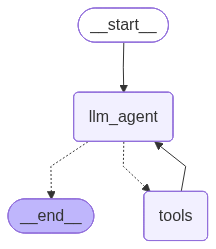

In [37]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

#### ReAct Flow

In [38]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025, please add 5 plus 5 and then multiply the result by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025, please add 5 plus 5 and then multiply the result by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (smfnmee1n)
 Call ID: smfnmee1n
  Args:
    end_date: 2025-03-03
    query: top AI news March 3 2025
    search_depth: advanced
    start_date: 2025-03-03
    time_range: day
    topic: news
  add (5xqs872ha)
 Call ID: 5xqs872ha
  Args:
    a: 5
    b: 5
  multiply (zs85t1j53)
 Call ID: zs85t1j53
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 400: When time_range is set, start_date or end_date cannot be set')}
================================= Tool Message =================================
Name: add

10
================================= Tool Message ==============================